In [2]:
import matplotlib.pyplot as plt

from ultralytics import YOLO

import onnx
import onnxruntime as ort

import openvino as ov

import cv2
import numpy as np

# TORCH

In [19]:
model = YOLO("../models/bubbles.pt", task="detect")

In [26]:
%%time
result = model("../datasets/train/images/0.jpg", imgsz=256)

image 1/1 C:\Users\Rusty\Projects\petpals-fishing\notebooks\..\datasets\train\images\0.jpg: 160x256 1 point, 1 button, 21.6ms
Speed: 1.0ms preprocess, 21.6ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 256)
CPU times: total: 156 ms
Wall time: 46.6 ms


In [7]:
result[0].boxes.xywh.tolist()

[[1319.643798828125, 626.0933837890625, 269.689697265625, 268.3941955566406],
 [103.00118255615234,
  1004.3318481445312,
  110.78059387207031,
  119.9281005859375]]

# ONNX

In [2]:
session = ort.InferenceSession("models/onnx/best3.onnx")

inputs = session.get_inputs()

input_width = inputs[0].shape[2]
input_height = inputs[0].shape[3]

In [34]:
image = cv2.imread("datasets/raw/images/288.jpg")

# Get the height and width of the input image
img_height, img_width = image.shape[:2]

# Convert the image color space from BGR to RGB
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image to match the input shape
img = cv2.resize(img, (input_width, input_height))

# Normalize the image data by dividing it by 255.0
image_data = np.array(img) / 255.0

# Transpose the image to have the channel dimension as the first dimension
image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

# Expand the dimensions of the image data to match the expected input shape
image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

In [18]:
outputs = session.run(None, {inputs[0].name: image_data})

In [19]:
def draw_detections(img, box, score, class_id):
        """
        Draws bounding boxes and labels on the input image based on the detected objects.

        Args:
            img: The input image to draw detections on.
            box: Detected bounding box.
            score: Corresponding detection score.
            class_id: Class ID for the detected object.

        Returns:
            None
        """

        # Extract the coordinates of the bounding box
        x1, y1, w, h = box
        classes = ["point"]
        color_palette = np.random.uniform(0, 255, size=(len(classes), 3))
        
        # Retrieve the color for the class ID
        color = color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f'{classes[class_id]}: {score:.2f}'

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                      cv2.FILLED)

        # Draw the label text on the image
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

In [20]:
output = np.transpose(np.squeeze(outputs[0]))

rows = output.shape[0]

boxes = []
scores = []
class_ids = []

x_factor = img_width / input_width
y_factor = img_height / input_height

 # Iterate over each row in the outputs array
for i in range(rows):
    # Extract the class scores from the current row
    classes_scores = output[i][4:]

    # Find the maximum score among the class scores
    max_score = np.amax(classes_scores)

    # If the maximum score is above the confidence threshold
    if max_score >= .9:
        # Get the class ID with the highest score
        class_id = np.argmax(classes_scores)

        # Extract the bounding box coordinates from the current row
        x, y, w, h = output[i][0], output[i][1], output[i][2], output[i][3]

        # Calculate the scaled coordinates of the bounding box
        left = int((x - w / 2) * x_factor)
        top = int((y - h / 2) * y_factor)
        width = int(w * x_factor)
        height = int(h * y_factor)

        # Add the class ID, score, and box coordinates to the respective lists
        class_ids.append(class_id)
        scores.append(max_score)
        boxes.append([left, top, width, height])

# Apply non-maximum suppression to filter out overlapping bounding boxes
indices = cv2.dnn.NMSBoxes(boxes, scores, .5, .7)

# Iterate over the selected indices after non-maximum suppression
for i in indices:
    # Get the box, score, and class ID corresponding to the index
    box = boxes[i]
    score = scores[i]
    class_id = class_ids[i]

    # Draw the detection on the input image
    draw_detections(image, box, score, class_id)



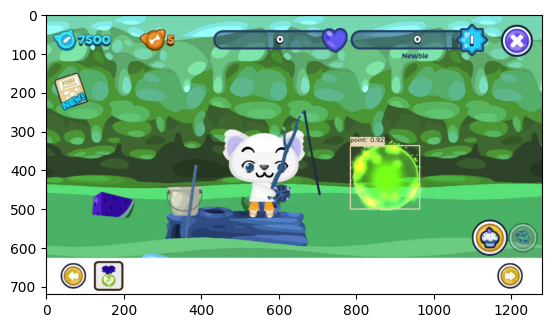

In [21]:
plt.imshow(image[::])

# OPEN VINO ##

In [25]:
core = ov.Core()

model = core.read_model(model="models/openvino/best3/best.xml")
compiled_model = core.compile_model(model=model, device_name="CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

In [35]:
result = compiled_model(image_data)[output_layer]

In [36]:
output = np.transpose(np.squeeze(result[0]))

rows = output.shape[0]

boxes = []
scores = []
class_ids = []

x_factor = img_width / input_width
y_factor = img_height / input_height

 # Iterate over each row in the outputs array
for i in range(rows):
    # Extract the class scores from the current row
    classes_scores = output[i][4:]

    # Find the maximum score among the class scores
    max_score = np.amax(classes_scores)

    # If the maximum score is above the confidence threshold
    if max_score >= .9:
        # Get the class ID with the highest score
        class_id = np.argmax(classes_scores)

        # Extract the bounding box coordinates from the current row
        x, y, w, h = output[i][0], output[i][1], output[i][2], output[i][3]

        # Calculate the scaled coordinates of the bounding box
        left = int((x - w / 2) * x_factor)
        top = int((y - h / 2) * y_factor)
        width = int(w * x_factor)
        height = int(h * y_factor)

        # Add the class ID, score, and box coordinates to the respective lists
        class_ids.append(class_id)
        scores.append(max_score)
        boxes.append([left, top, width, height])

# Apply non-maximum suppression to filter out overlapping bounding boxes
indices = cv2.dnn.NMSBoxes(boxes, scores, .5, .7)

# Iterate over the selected indices after non-maximum suppression
for i in indices:
    # Get the box, score, and class ID corresponding to the index
    box = boxes[i]
    score = scores[i]
    class_id = class_ids[i]

    # Draw the detection on the input image
    draw_detections(image, box, score, class_id)



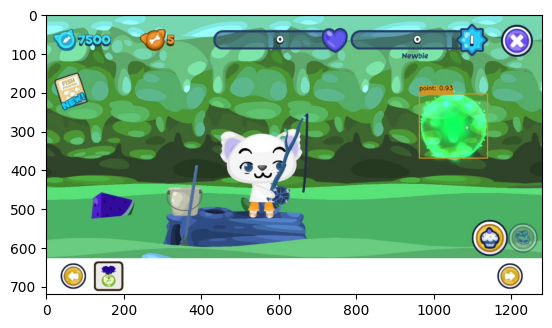

In [37]:
plt.imshow(image)